In [2]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

import os
os.environ["TERRA_CONFIG_PATH"] = "/home/sabri/code/spr-21/terra_config.json"

import terra 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

In [2]:
from mosaic import DataPanel, NumpyArrayColumn
from mosaic.contrib.wilds import get_wilds_datapane

In [14]:
from spr.data.celeb import build_celeb_df, get_celeb_dp
celeb_dp = get_celeb_dp(build_celeb_df.out(141, load=True))
celeb_dp = celeb_dp.filter(
    lambda x: x["split"] == "valid", input_columns=["split"], num_workers=0
)
celeb_dp["input"]._materialize = False
celeb_dp["img"]._materialize = False
celeb_dp = celeb_dp[:]
celeb_dp["input"]._materialize = True
celeb_dp["img"]._materialize = True

In [18]:
celeb_dp = get_celeb_dp(build_celeb_df.out(141, load=True))

celeb_dp["split"].data == "valid"

array([False, False, False, ..., False, False, False])

In [4]:
# load feedback
feedback_dp = terra.out(run_id=282)[0].load()
feedback_files = set(feedback_dp["file"])
size = feedback_dp["feedback_pos_mask"].shape[1:]
if "feedback_label" not in celeb_dp.column_names:
    celeb_dp.add_column("feedback_label", NumpyArrayColumn(["unlabeled"] * len(celeb_dp)))
if  "feedback_pos_mask" not in celeb_dp.column_names:
    celeb_dp.add_column(
        "feedback_pos_mask",
        NumpyArrayColumn(np.zeros((len(celeb_dp), *size))),
    )
if "feedback_neg_mask" not in celeb_dp.column_names:
    celeb_dp.add_column(
        "feedback_neg_mask",
        NumpyArrayColumn(np.zeros((len(celeb_dp), *size))),
    )

for batch in feedback_dp.batch(batch_size=1, num_workers=0):
    index = np.where(celeb_dp["file"] == batch["file"])
    celeb_dp["feedback_label"][index[0]] = batch["feedback_label"]
    celeb_dp["feedback_neg_mask"][index[0]] = batch["feedback_neg_mask"]
    celeb_dp["feedback_pos_mask"][index[0]] = batch["feedback_pos_mask"]


In [137]:
from spr.feedback import solicit_feedback_imgs

solicit_feedback_imgs(
    celeb_dp,
    num_examples=500,
    img_column="img",
    label_column="wearing_necktie",
    rank_by="feedback_preds_max",
    size=(256, 256)
)

Running locally at: http://127.0.0.1:7862/
To create a public link, set `share=True` in `launch()`.


(<Flask 'gradio.networking'>, 'http://127.0.0.1:7862/', None)

In [5]:
@terra.Task
def save_feedback(label, run_dir=None):
    feedback_dp = celeb_dp.filter(
        lambda x: x["feedback_label"] != "unlabeled",
        input_columns=["feedback_label"]
    )
    feedback_dp["img"]._materialize = False
    return feedback_dp[:], label

In [6]:
###### LOAD ######
feedback_dp = save_feedback.out()[0].load()

In [6]:
###### SAVE ######
save_feedback("wearing_necktie")

In [5]:
from spr.vision import train

run_ids = train.get_runs().id
run_ids = run_ids[(run_ids >= 241) * (run_ids <271)]
target_to_run_id =  {train.inp(run_id)["target_column"]: run_id for run_id in run_ids}

textattack: Updating TextAttack package dependencies.
textattack: Downloading NLTK required packages.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
textattack: Downloading https://textattack.s3.amazonaws.com/word_embeddings/paragramcf.
100%|██████████| 481M/481M [00:13<00:00, 36.7MB/s]
textattack: Unzipping file /root/.cache/textattack

In [34]:
from spr.bss_dp import SourceSeparator
model = train.out(target_to_run_id["eyeglasses"], load=True)
separator = SourceSeparator(model=model)

/home/common/envs/conda/envs/rg-sabri/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [35]:
celeb_dp = separator.prepare_dp(celeb_dp, batch_size=16)

In [36]:
# prepare logistic regression
def pool_feedback(x: DataPanel):
    return {
        f"{feedback_mask}_pool": nn.functional.avg_pool2d(
            input=torch.tensor(x[feedback_mask]).to(float), kernel_size=(32,32)
        ).numpy()
        for feedback_mask in ["feedback_neg_mask", "feedback_pos_mask"]
    }

dp =  celeb_dp.filter(
    lambda x: x["feedback_label"] != "unlabeled",
    input_columns=["feedback_label"]
)

In [37]:
mask_pool = dp.map(
    pool_feedback, 
    input_columns=["feedback_neg_mask", "feedback_pos_mask"], 
    batched=True,
    batch_size=16,      
    num_workers=0
)

In [38]:
x = dp["activation"].transpose(0, 2, 3, 1).reshape(-1, 512)
y = mask_pool["feedback_pos_mask_pool"].flatten() - mask_pool["feedback_neg_mask_pool"].flatten()

In [39]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import normalize

x = normalize(x)
threshold = 0.2
strat = "binary_all"
if strat == "balanced_multiclass":
    cat_y = np.copy(y)
    cat_y[(y < threshold) *  (y > -threshold)] = 0
    cat_y[y > threshold] = 1
    cat_y[y < -threshold] = 2
    lr = LogisticRegression(multi_class="ovr", class_weight="balanced")
    lr = lr.fit(x, cat_y)
elif strat == "binary":
    cat_y = np.copy(y)
    mask = ((y < threshold) *  (y > -threshold)).data
    lr = LogisticRegression(multi_class="ovr", class_weight="balanced")
    lr = lr.fit(x[mask], (y > 0)[mask])
elif strat == "binary_all":
    cat_y = np.copy(y)
    mask = ((y < threshold) *  (y > -threshold)).data
    lr = LogisticRegression(multi_class="ovr", class_weight="balanced")
    lr = lr.fit(x, (y > 0.2))
else:
    raise ValueError

In [40]:
from sklearn.metrics import roc_auc_score
x_test = celeb_dp["activation"].transpose(0, 2, 3, 1).reshape(-1, 512)
x_test = normalize(x_test)
y_test_preds = lr.predict_proba(x_test)
celeb_dp.add_column(
    "feedback_preds", y_test_preds[:, 1].reshape(-1, 8, 8), overwrite=True
)

celeb_dp.add_column(
    "feedback_preds_max", celeb_dp["feedback_preds"].max(axis=(1,2)), overwrite=True
)

roc_auc_score(celeb_dp["eyeglasses"], celeb_dp["feedback_preds_max"])

0.9929445027850801

In [30]:
df = pd.DataFrame({
    column: celeb_dp[column].data
    for column in ["feedback_preds_max", "male", "wearing_necktie", "img_path", "index"]
})
df = df.sort_values("feedback_preds_max")

In [31]:
df = df.sort_values("feedback_preds_max")

<ipython-input-32-c8e114f07ab3>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, axes = plt.subplots(1, 2)


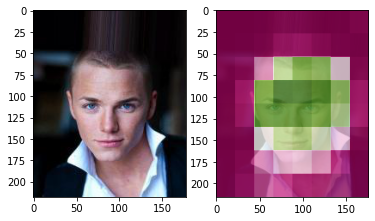

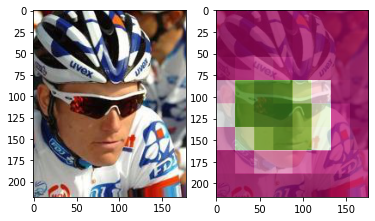

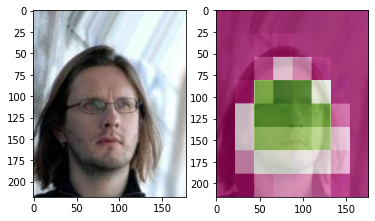

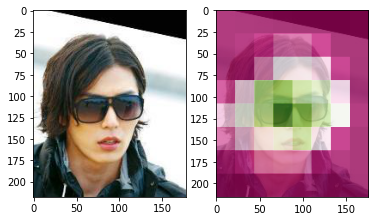

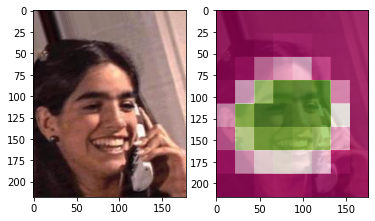

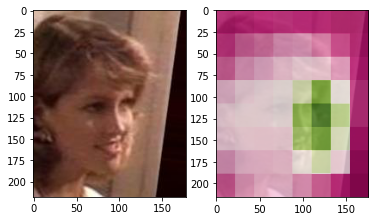

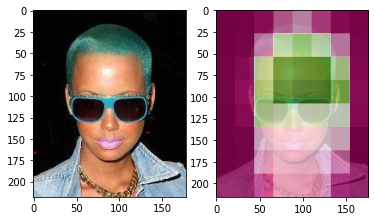

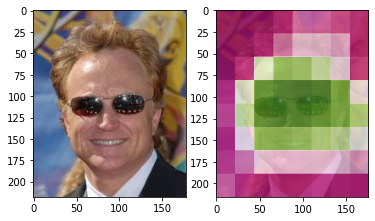

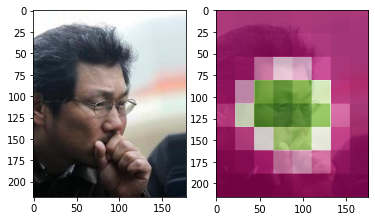

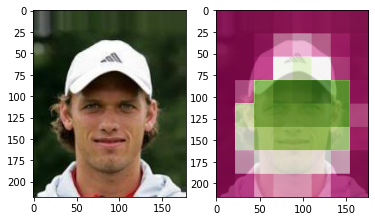

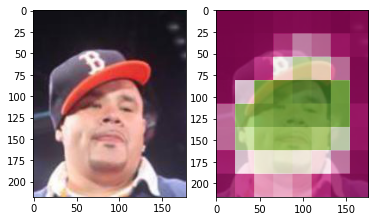

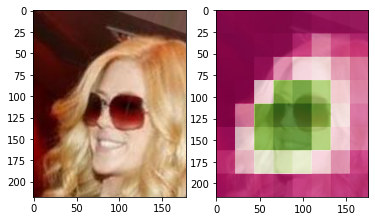

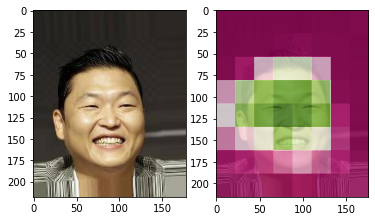

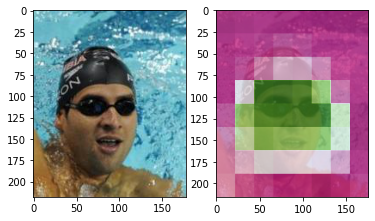

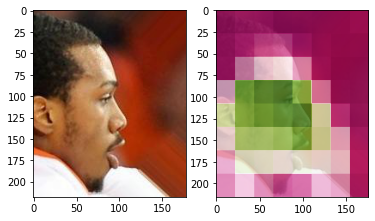

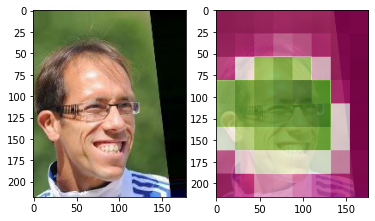

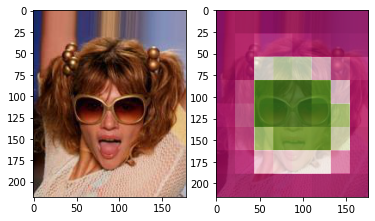

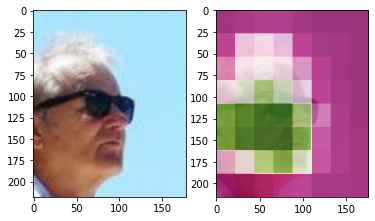

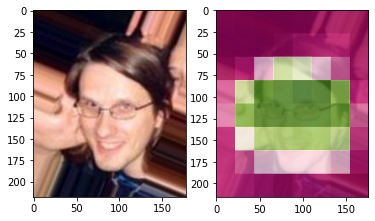

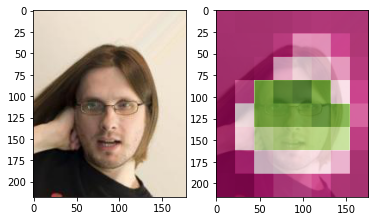

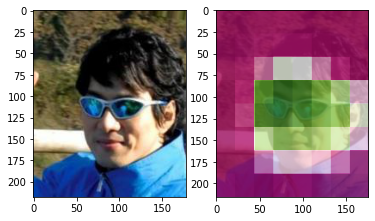

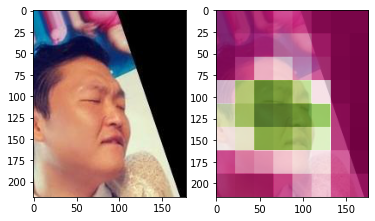

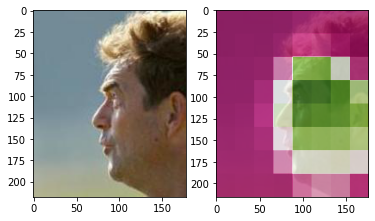

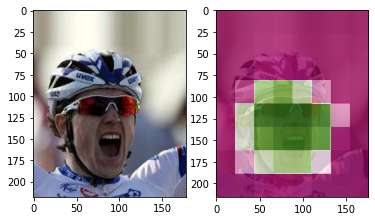

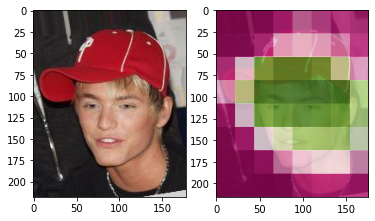

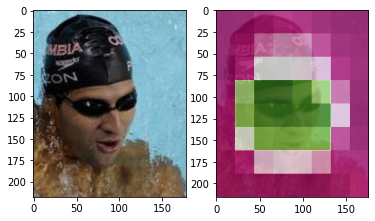

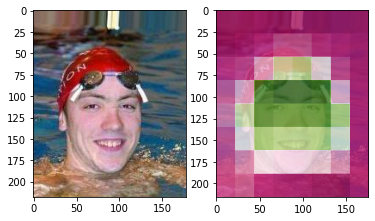

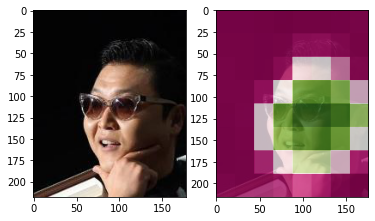

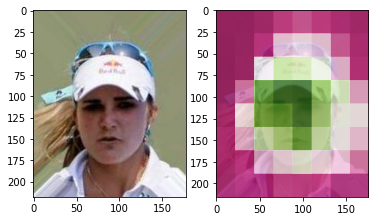

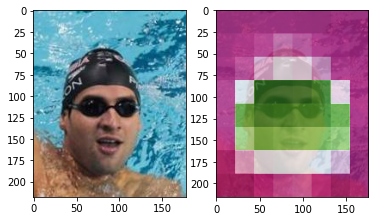

In [32]:
dp = celeb_dp 
global_min = dp["feedback_preds"].min()
global_max = dp["feedback_preds"].max()
for row in dp[np.array(df.index[-30:])]:
   _, axes = plt.subplots(1, 2)
   inp = np.array(row["img"])
   axes[0].imshow(inp)
   axes[1].imshow(inp)
   
   preds = np.array(row["feedback_preds"])
   preds = preds.repeat(
       inp.shape[0] / preds.shape[0], axis=0
   ).repeat(inp.shape[1] / preds.shape[1], axis=1)
   axes[1].imshow(
       preds,
       alpha=0.79, 
       cmap="PiYG",
       vmin=global_min,
       vmax=global_max
   )

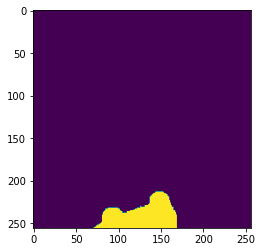

In [107]:
plt.imshow(celeb_dp[2795]["feedback_neg_mask"])

In [105]:
plt.imshow(celeb_dp[2795]["feedback_neg_mask_pool"])

KeyError: 'feedback_neg_mask_pool'

In [9]:
model_df = terra.out(290, load=True)

In [10]:
model_df.to_dict()

{'run_id': {0: 240,
  1: 239,
  2: 231,
  3: 232,
  4: 259,
  5: 256,
  6: 243,
  7: 258,
  8: 254,
  9: 242,
  10: 237,
  11: 267,
  12: 266,
  13: 245,
  14: 263,
  15: 241,
  16: 249,
  17: 252,
  18: 262,
  19: 260,
  20: 264,
  21: 238,
  22: 265,
  23: 257,
  24: 230,
  25: 251,
  26: 233,
  27: 235,
  28: 247,
  29: 246,
  30: 236,
  31: 261,
  32: 255,
  33: 234,
  34: 268,
  35: 253,
  36: 244,
  37: 250,
  38: 229,
  39: 248},
 'build_df_run_id': {0: 29,
  1: 29,
  2: 29,
  3: 29,
  4: 29,
  5: 29,
  6: 29,
  7: 29,
  8: 29,
  9: 29,
  10: 29,
  11: 29,
  12: 29,
  13: 29,
  14: 29,
  15: 29,
  16: 29,
  17: 29,
  18: 29,
  19: 29,
  20: 29,
  21: 29,
  22: 29,
  23: 29,
  24: 29,
  25: 29,
  26: 29,
  27: 29,
  28: 29,
  29: 29,
  30: 29,
  31: 29,
  32: 29,
  33: 29,
  34: 29,
  35: 29,
  36: 29,
  37: 29,
  38: 29,
  39: 29},
 'run_dir': {0: '/home/common/models/celeba/_runs/240',
  1: '/home/common/models/celeba/_runs/239',
  2: '/home/common/models/celeba/_runs/231',
  3

In [21]:
terra.out(309).load()

model_target  model_run_id  scribble_run_id  scribble_target     auroc
0   brown_hair           240              270  wearing_necktie  0.909026
1   brown_hair           240              282       eyeglasses  0.495965
2       blurry           239              270  wearing_necktie  0.727446
3       blurry           239              282       eyeglasses  0.780709
4   attractive           231              270  wearing_necktie  0.707526
5   attractive           231              282       eyeglasses  0.817574